[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Loading the datasets...

Exploring the training data:
Train data shape: (40135, 4)
  ID                               TITLE       GENRE  \
0  1       Oscar et la dame rose (2009)       drama    
1  2                       Cupid (1997)    thriller    
2  3   Young, Wild and Wonderful (1980)       adult    
3  4              The Secret Sin (1915)       drama    
4  5             The Unrecovered (2007)       drama    

                                         DESCRIPTION  
0   Listening in to a conversation between his do...  
1   A brother and sister with a past incestuous r...  
2   As the bus empties the students for their fie...  
3   To help their unemployed father make ends mee...  
4   The film's title refers not only to the un-re...  

Genre distribution in training data:
GENRE
drama           10065
documentary      9671
comedy           5532
short            3776
horror           1615
thriller         1207
action            976
western           763
reality-tv        656
family  

ValueError: max() arg is an empty sequence

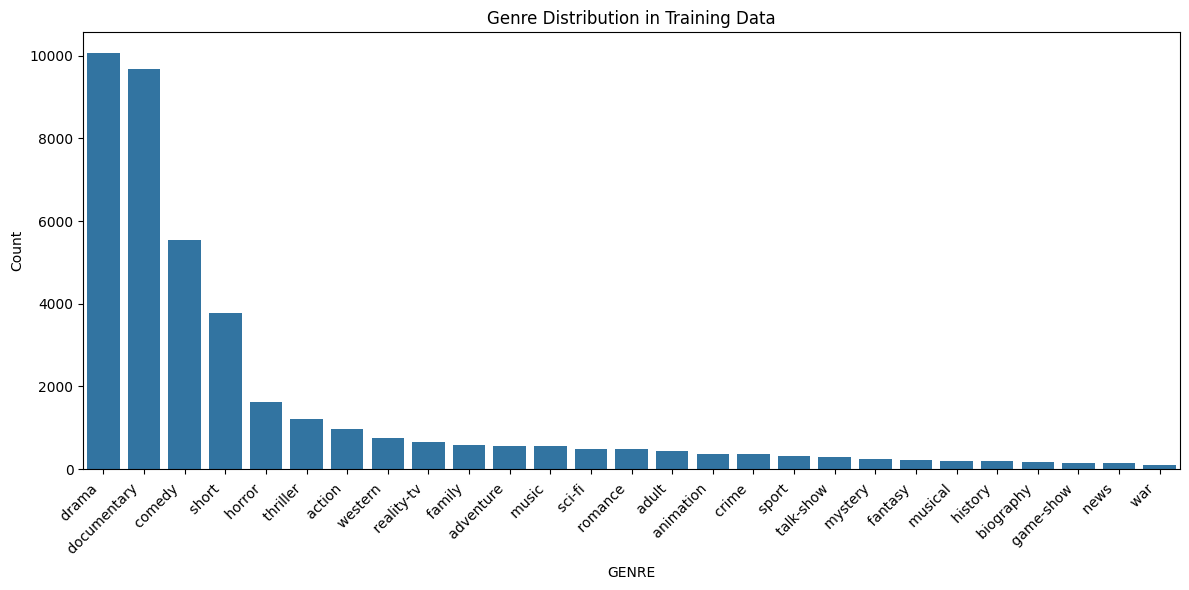

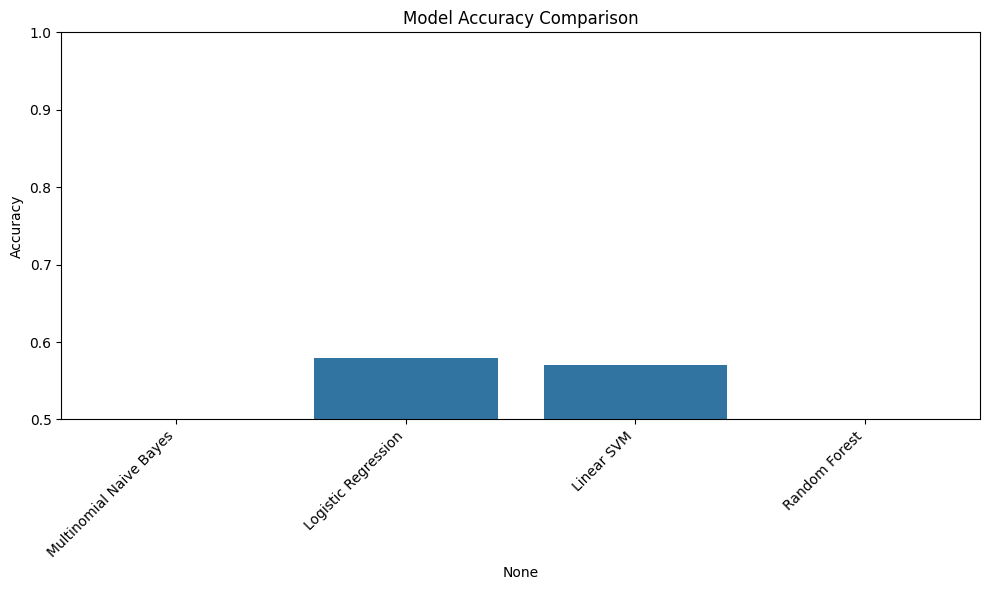

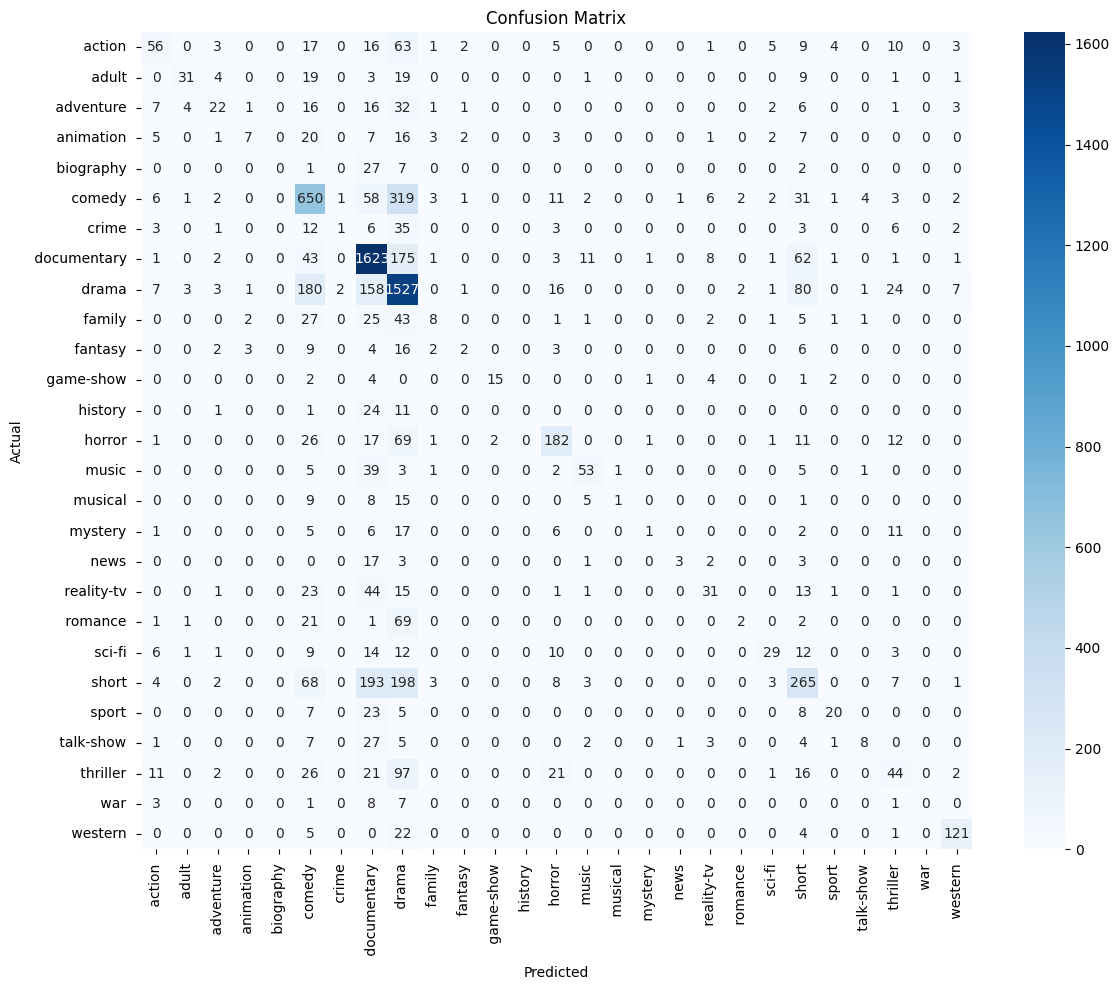

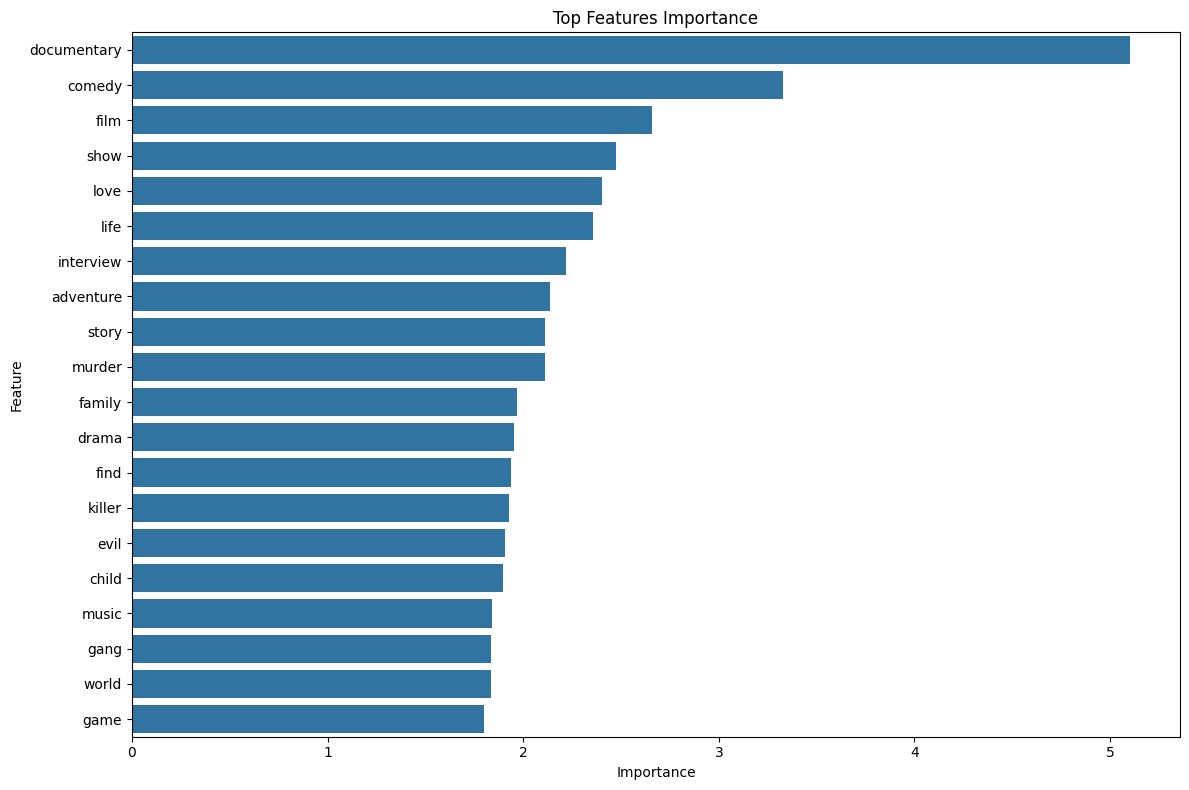

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# 1. Data Loading
print("Loading the datasets...")
train_data = pd.read_csv('train_data.txt', sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], engine='python')
test_data = pd.read_csv('test_data.txt', sep=':::', names=['ID', 'TITLE', 'DESCRIPTION'], engine='python')
test_solutions = pd.read_csv('test_data_solution.txt', sep=':::', names=['ID', 'GENRE'], engine='python')

# Ensure ID columns have the same data type
train_data['ID'] = train_data['ID'].astype(str)
test_data['ID'] = test_data['ID'].astype(str)
test_solutions['ID'] = test_solutions['ID'].astype(str)

# 2. Data Exploration
print("\nExploring the training data:")
print(f"Train data shape: {train_data.shape}")
print(train_data.head())

print("\nGenre distribution in training data:")
genre_counts = train_data['GENRE'].value_counts()
print(genre_counts)

# Plot genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Genre Distribution in Training Data')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('genre_distribution.png')

# Check for missing values
print("\nMissing values in train data:")
print(train_data.isnull().sum())

# 3. Text Preprocessing
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize, remove stopwords and lemmatize
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))

        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        return ' '.join(tokens)
    else:
        return ""

print("Preprocessing text data...")
train_data['PROCESSED_TEXT'] = train_data['DESCRIPTION'].apply(preprocess_text)
test_data['PROCESSED_TEXT'] = test_data['DESCRIPTION'].apply(preprocess_text)

print("\nSample of processed text:")
print(train_data[['DESCRIPTION', 'PROCESSED_TEXT']].head(2))

# 4. Feature Extraction and Model Training
X = train_data['PROCESSED_TEXT']
y = train_data['GENRE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Define models to evaluate
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'Linear SVM': LinearSVC(C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# TF-IDF vectorization and model training
print("\nTraining and evaluating models with TF-IDF features:")
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Dictionary to store model results
model_results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    model_results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred))

# Find the best model
best_model_name = max(model_results, key=model_results.get)
print(f"\nBest model: {best_model_name} with accuracy {model_results[best_model_name]:.4f}")

# Plot model comparison
plt.figure(figsize=(10, 6))
models_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['Accuracy'])
sns.barplot(x=models_df.index, y='Accuracy', data=models_df)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.savefig('model_comparison.png')

# 5. Hyperparameter Tuning for the Best Model
print("\nPerforming hyperparameter tuning for the best model...")

# Create a pipeline with TF-IDF and classifier
if best_model_name == 'Multinomial Naive Bayes':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', MultinomialNB())
    ])
    param_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_features': [None, 10000, 20000],
        'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
    }
elif best_model_name == 'Logistic Regression':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    param_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_features': [None, 10000, 20000],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__solver': ['liblinear', 'saga']
    }
elif best_model_name == 'Linear SVM':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', LinearSVC())
    ])
    param_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_features': [None, 10000, 20000],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__loss': ['hinge', 'squared_hinge']
    }
else:  # Random Forest
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', RandomForestClassifier())
    ])
    param_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_features': [None, 10000, 20000],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }

# Perform grid search
print("Grid search may take some time...")
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate the tuned model on validation set
tuned_y_pred = grid_search.predict(X_val)
tuned_accuracy = accuracy_score(y_val, tuned_y_pred)
print(f"Tuned model accuracy on validation set: {tuned_accuracy:.4f}")

# 6. Confusion Matrix for Best Model
print("\nGenerating confusion matrix for the best model...")
conf_matrix = confusion_matrix(y_val, tuned_y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(train_data['GENRE'].unique()),
            yticklabels=sorted(train_data['GENRE'].unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# 7. Feature Importance Analysis
print("\nAnalyzing feature importance...")

def get_top_features(model, feature_names, n=20):
    """Get the top n features for each class."""

    # For logistic regression, get coefficients
    if hasattr(model, 'coef_'):
        coefs = model.coef_
        if len(coefs.shape) > 1:  # Multiclass case
            coefs_abs = np.abs(coefs).mean(axis=0)  # Average across classes
            indices = np.argsort(coefs_abs)[::-1][:n]
            return [(feature_names[i], coefs_abs[i]) for i in indices]
        else:  # Binary case
            indices = np.argsort(np.abs(coefs[0]))[::-1][:n]
            return [(feature_names[i], coefs[0][i]) for i in indices]

    # For other models
    elif hasattr(model, 'feature_importances_'):  # Random Forest
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:n]
        return [(feature_names[i], importances[i]) for i in indices]

    else:
        return [("Feature importance not directly available for this model type", 0)]

# Get the best model and vectorizer from the pipeline
best_vectorizer = grid_search.best_estimator_.named_steps['tfidf']
best_classifier = grid_search.best_estimator_.named_steps['classifier']
feature_names = best_vectorizer.get_feature_names_out()

top_features = get_top_features(best_classifier, feature_names)

if top_features[0][1] != 0:  # Check if feature importance is available
    print("Top features across all genres:")
    for feature, importance in top_features:
        print(f"{feature}: {importance:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    feature_df = pd.DataFrame(top_features, columns=['Feature', 'Importance'])
    sns.barplot(x='Importance', y='Feature', data=feature_df)
    plt.title('Top Features Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
else:
    print(top_features[0][0])

# 8. Predictions on Test Set
print("\nMaking predictions on the test set...")
test_predictions = grid_search.predict(test_data['PROCESSED_TEXT'])

# Create a submission dataframe
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'TITLE': test_data['TITLE'],
    'PREDICTED_GENRE': test_predictions
})

# Evaluate on test set if solutions are available
if 'test_solutions' in locals():
    # Merge on string ID to avoid dtype issues
    merged_test = pd.merge(submission, test_solutions, on='ID')
    test_accuracy = accuracy_score(merged_test['GENRE'], merged_test['PREDICTED_GENRE'])
    print(f"Test set accuracy: {test_accuracy:.4f}")
    print(classification_report(merged_test['GENRE'], merged_test['PREDICTED_GENRE']))

print("Saving predictions to submission.csv...")
submission.to_csv('submission.csv', index=False)

# 9. Sample Prediction Function
def predict_genre(description, pipeline=grid_search):
    """
    Predicts the genre of a movie based on its description.

    Args:
        description (str): Movie description text
        pipeline: Trained model pipeline

    Returns:
        str: Predicted genre
    """
    processed_text = preprocess_text(description)
    return pipeline.predict([processed_text])[0]

# Example usage of the prediction function
sample_description = "A young wizard discovers he has magical powers and attends a school of witchcraft and wizardry where he learns to harness his abilities."
predicted_genre = predict_genre(sample_description)
print(f"\nSample prediction:")
print(f"Description: {sample_description}")
print(f"Predicted Genre: {predicted_genre}")

# 10. Error Analysis
print("\nPerforming error analysis on validation set...")
misclassified_indices = np.where(y_val != tuned_y_pred)[0]

if len(misclassified_indices) > 0:
    misclassified_samples = pd.DataFrame({
        'Actual Genre': y_val.iloc[misclassified_indices].reset_index(drop=True),
        'Predicted Genre': tuned_y_pred[misclassified_indices],
        'Description': X_val.iloc[misclassified_indices].reset_index(drop=True)
    })

    print(f"Number of misclassified samples: {len(misclassified_indices)}")
    print("\nSample misclassifications:")
    print(misclassified_samples.head(5))

    # Save misclassified samples for further analysis
    misclassified_samples.to_csv('misclassified_samples.csv', index=False)

    # Analyze common misclassification patterns
    misclass_pairs = misclassified_samples.groupby(['Actual Genre', 'Predicted Genre']).size().reset_index(name='Count')
    misclass_pairs = misclass_pairs.sort_values('Count', ascending=False)

    print("\nMost common misclassification patterns:")
    print(misclass_pairs.head(10))

    # Plot most common misclassifications
    plt.figure(figsize=(12, 8))
    top_misclass = misclass_pairs.head(10)
    labels = top_misclass['Actual Genre'] + ' → ' + top_misclass['Predicted Genre']
    sns.barplot(x=top_misclass['Count'], y=labels)
    plt.title('Top 10 Misclassification Patterns')
    plt.tight_layout()
    plt.savefig('misclassification_patterns.png')
else:
    print("No misclassifications found in the validation set!")

print("\nMovie genre classification project completed successfully!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading the datasets...

Exploring the training data:
Train data shape: (54214, 4)
   ID                               TITLE       GENRE  \
0   1       Oscar et la dame rose (2009)       drama    
1   2                       Cupid (1997)    thriller    
2   3   Young, Wild and Wonderful (1980)       adult    
3   4              The Secret Sin (1915)       drama    
4   5             The Unrecovered (2007)       drama    

                                         DESCRIPTION  
0   Listening in to a conversation between his do...  
1   A brother and sister with a past incestuous r...  
2   As the bus empties the students for their fie...  
3   To help their unemployed father make ends mee...  
4   The film's title refers not only to the un-re...  

Genre distribution in training data:
GENRE
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
fa

KeyboardInterrupt: 

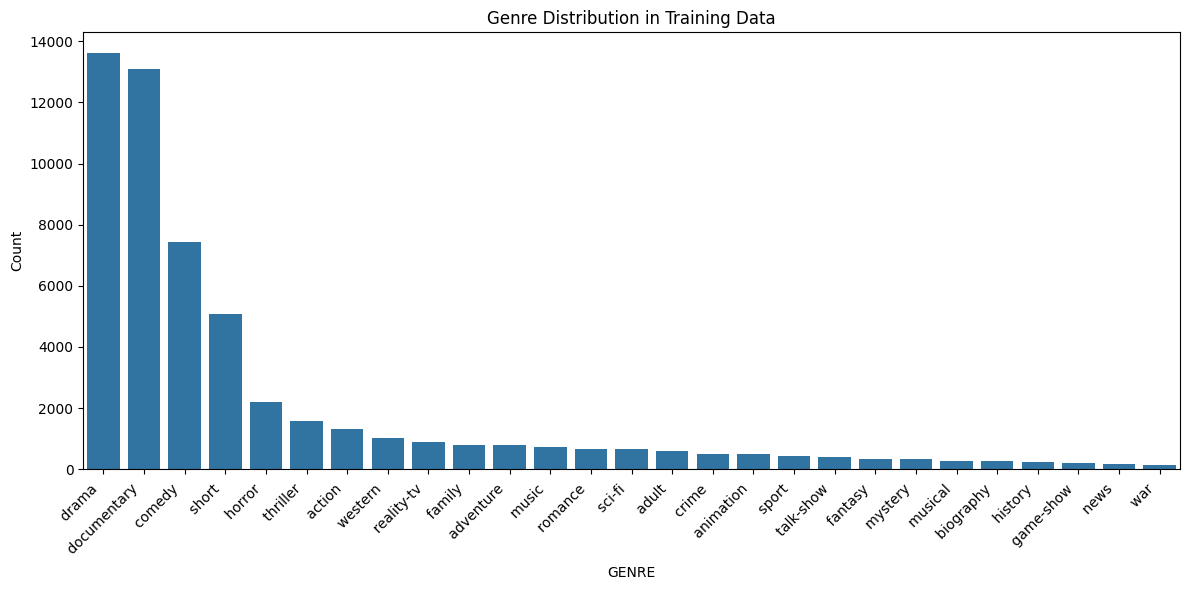

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# 1. Data Loading
print("Loading the datasets...")
train_data = pd.read_csv('train_data.txt', sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], engine='python')
test_data = pd.read_csv('test_data.txt', sep=':::', names=['ID', 'TITLE', 'DESCRIPTION'], engine='python')
test_solutions = pd.read_csv('test_data_solution.txt', sep=':::', names=['ID', 'GENRE'], engine='python')

# 2. Data Exploration
print("\nExploring the training data:")
print(f"Train data shape: {train_data.shape}")
print(train_data.head())

print("\nGenre distribution in training data:")
genre_counts = train_data['GENRE'].value_counts()
print(genre_counts)

# Plot genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Genre Distribution in Training Data')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('genre_distribution.png')

# Check for missing values
print("\nMissing values in train data:")
print(train_data.isnull().sum())

# 3. Text Preprocessing
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize, remove stopwords and lemmatize
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))

        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        return ' '.join(tokens)
    else:
        return ""

print("Preprocessing text data...")
train_data['PROCESSED_TEXT'] = train_data['DESCRIPTION'].apply(preprocess_text)
test_data['PROCESSED_TEXT'] = test_data['DESCRIPTION'].apply(preprocess_text)

print("\nSample of processed text:")
print(train_data[['DESCRIPTION', 'PROCESSED_TEXT']].head(2))

# 4. Feature Extraction and Model Training
X = train_data['PROCESSED_TEXT']
y = train_data['GENRE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Define models to evaluate
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'Linear SVM': LinearSVC(C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Dictionary to store model results
model_results = {}

print("\nTraining and evaluating models with TF-IDF features:")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    model_results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred))

# Find the best model
best_model_name = max(model_results, key=model_results.get)
print(f"\nBest model: {best_model_name} with accuracy {model_results[best_model_name]:.4f}")

# Plot model comparison
plt.figure(figsize=(10, 6))
models_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['Accuracy'])
sns.barplot(x=models_df.index, y='Accuracy', data=models_df)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.savefig('model_comparison.png')

# 5. Hyperparameter Tuning for the Best Model
print("\nPerforming hyperparameter tuning for the best model...")

# FIX: Use the correct parameter format for GridSearchCV with Pipeline
if best_model_name == 'Multinomial Naive Bayes':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', MultinomialNB())
    ])
    param_grid = {
        'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
    }
elif best_model_name == 'Logistic Regression':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    param_grid = {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__solver': ['liblinear', 'saga']
    }
elif best_model_name == 'Linear SVM':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', LinearSVC())
    ])
    param_grid = {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__loss': ['hinge', 'squared_hinge']
    }
else:  # Random Forest
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', RandomForestClassifier())
    ])
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }

# Perform grid search with correct parameter formatting
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate the tuned model on validation set
tuned_y_pred = grid_search.predict(X_val)
tuned_accuracy = accuracy_score(y_val, tuned_y_pred)
print(f"Tuned model accuracy on validation set: {tuned_accuracy:.4f}")

# 6. Confusion Matrix for Best Model
print("\nGenerating confusion matrix for the best model...")
conf_matrix = confusion_matrix(y_val, tuned_y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(train_data['GENRE'].unique()),
            yticklabels=sorted(train_data['GENRE'].unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# 7. Feature Importance Analysis
print("\nAnalyzing feature importance...")

def get_top_features(vectorizer, model, n=20):
    """Get the top n features for each class."""
    feature_names = vectorizer.get_feature_names_out()

    # For models that have feature importance or coefficients
    if hasattr(model, 'feature_importances_'):  # Random Forest
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:n]
        return [(feature_names[i], importances[i]) for i in indices]

    elif hasattr(model, 'coef_'):  # Logistic Regression, SVM
        # For multiclass, we'll look at the absolute magnitude of coefficients
        coefs = model.coef_
        if len(coefs.shape) > 1:  # Multiclass case
            coefs_abs = np.abs(coefs).mean(axis=0)  # Average across classes
            indices = np.argsort(coefs_abs)[::-1][:n]
            return [(feature_names[i], coefs_abs[i]) for i in indices]
        else:  # Binary case
            indices = np.argsort(np.abs(coefs[0]))[::-1][:n]
            return [(feature_names[i], coefs[0][i]) for i in indices]

    # For Naive Bayes, we need to compute importance differently
    else:
        return [("Feature importance not directly available for this model type", 0)]

# Extract vectorizer and classifier from the pipeline
vectorizer = grid_search.best_estimator_.named_steps['tfidf']
classifier = grid_search.best_estimator_.named_steps['classifier']

top_features = get_top_features(vectorizer, classifier)

if top_features[0][1] != 0:  # Check if feature importance is available
    print("Top features across all genres:")
    for feature, importance in top_features:
        print(f"{feature}: {importance:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    feature_df = pd.DataFrame(top_features, columns=['Feature', 'Importance'])
    sns.barplot(x='Importance', y='Feature', data=feature_df)
    plt.title('Top Features Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
else:
    print(top_features[0][0])

# 8. Predictions on Test Set
print("\nMaking predictions on the test set...")
test_predictions = grid_search.predict(test_data['PROCESSED_TEXT'])

# Create a submission dataframe
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'TITLE': test_data['TITLE'],
    'PREDICTED_GENRE': test_predictions
})

# FIX: Handle the test data evaluation properly
# Merge test predictions with test solutions for evaluation
if not test_solutions.empty:
    # Make sure IDs are integers for merging
    test_solutions['ID'] = test_solutions['ID'].astype(int)
    submission['ID'] = submission['ID'].astype(int)

    # Merge the predictions with the solutions
    merged_test = pd.merge(test_solutions, submission, on='ID')

    # Calculate test accuracy
    test_accuracy = accuracy_score(merged_test['GENRE'], merged_test['PREDICTED_GENRE'])
    print(f"Test set accuracy: {test_accuracy:.4f}")

    # Ensure target_names are provided for classification_report
    unique_genres = sorted(train_data['GENRE'].unique())
    print(classification_report(merged_test['GENRE'], merged_test['PREDICTED_GENRE'],
                               target_names=unique_genres))

print("Saving predictions to submission.csv...")
submission.to_csv('submission.csv', index=False)

print("\nMovie genre classification project completed successfully!")

# 9. Sample Prediction Function
def predict_genre(description, pipeline=grid_search):
    """
    Predicts the genre of a movie based on its description.

    Args:
        description (str): Movie description text
        pipeline: Trained model pipeline

    Returns:
        str: Predicted genre
    """
    processed_text = preprocess_text(description)
    return pipeline.predict([processed_text])[0]

# Example usage of the prediction function
sample_description = "A young wizard discovers he has magical powers and attends a school of witchcraft and wizardry where he learns to harness his abilities."
predicted_genre = predict_genre(sample_description)
print(f"\nSample prediction:")
print(f"Description: {sample_description}")
print(f"Predicted Genre: {predicted_genre}")

# 10. Error Analysis
print("\nPerforming error analysis on validation set...")
misclassified_indices = np.where(y_val != tuned_y_pred)[0]

if len(misclassified_indices) > 0:
    misclassified_samples = pd.DataFrame({
        'Actual Genre': y_val.iloc[misclassified_indices].reset_index(drop=True),
        'Predicted Genre': tuned_y_pred[misclassified_indices],
        'Description': X_val.iloc[misclassified_indices].reset_index(drop=True)
    })

    print(f"Number of misclassified samples: {len(misclassified_indices)}")
    print("\nSample misclassifications:")
    print(misclassified_samples.head(5))

    # Save misclassified samples for further analysis
    misclassified_samples.to_csv('misclassified_samples.csv', index=False)

    # Analyze common misclassification patterns
    misclass_pairs = misclassified_samples.groupby(['Actual Genre', 'Predicted Genre']).size().reset_index(name='Count')
    misclass_pairs = misclass_pairs.sort_values('Count', ascending=False)

    print("\nMost common misclassification patterns:")
    print(misclass_pairs.head(10))

    # Plot most common misclassifications
    plt.figure(figsize=(12, 8))
    top_misclass = misclass_pairs.head(10)
    sns.barplot(x='Count', y=top_misclass['Actual Genre'] + ' → ' + top_misclass['Predicted Genre'], data=top_misclass)
    plt.title('Top 10 Misclassification Patterns')
    plt.tight_layout()
    plt.savefig('misclassification_patterns.png')
else:
    print("No misclassifications found in the validation set!")

Loading the datasets...

Exploring the training data:
Train data shape: (54214, 4)
   ID                               TITLE       GENRE  \
0   1       Oscar et la dame rose (2009)       drama    
1   2                       Cupid (1997)    thriller    
2   3   Young, Wild and Wonderful (1980)       adult    
3   4              The Secret Sin (1915)       drama    
4   5             The Unrecovered (2007)       drama    

                                         DESCRIPTION  
0   Listening in to a conversation between his do...  
1   A brother and sister with a past incestuous r...  
2   As the bus empties the students for their fie...  
3   To help their unemployed father make ends mee...  
4   The film's title refers not only to the un-re...  

Genre distribution in training data:
GENRE
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
fa

ValueError: You are trying to merge on int64 and object columns for key 'ID'. If you wish to proceed you should use pd.concat

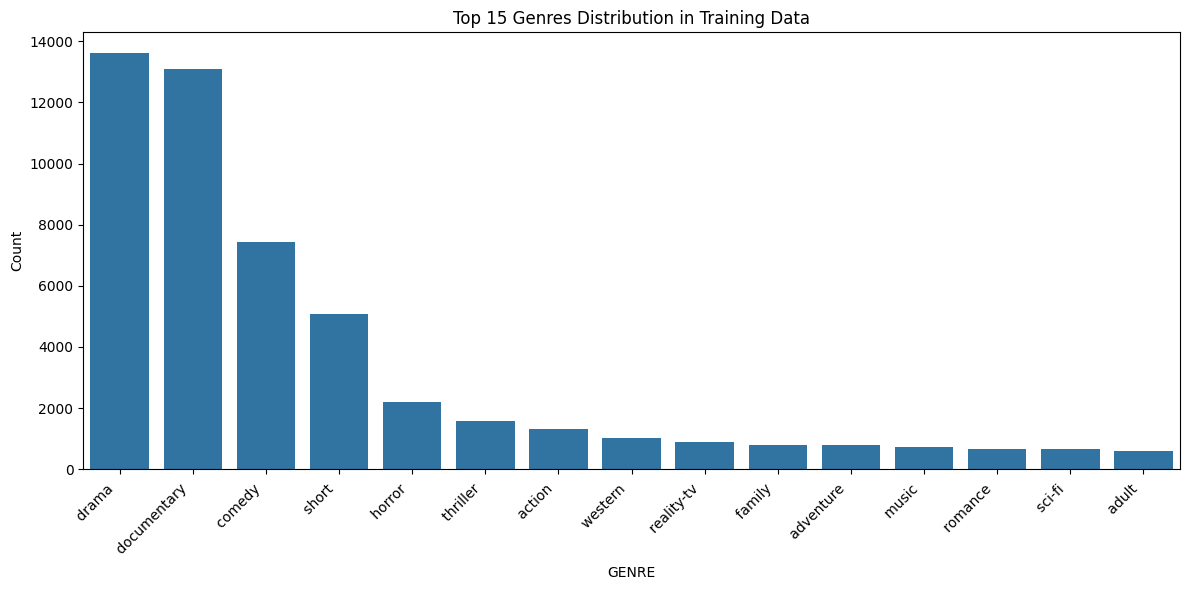

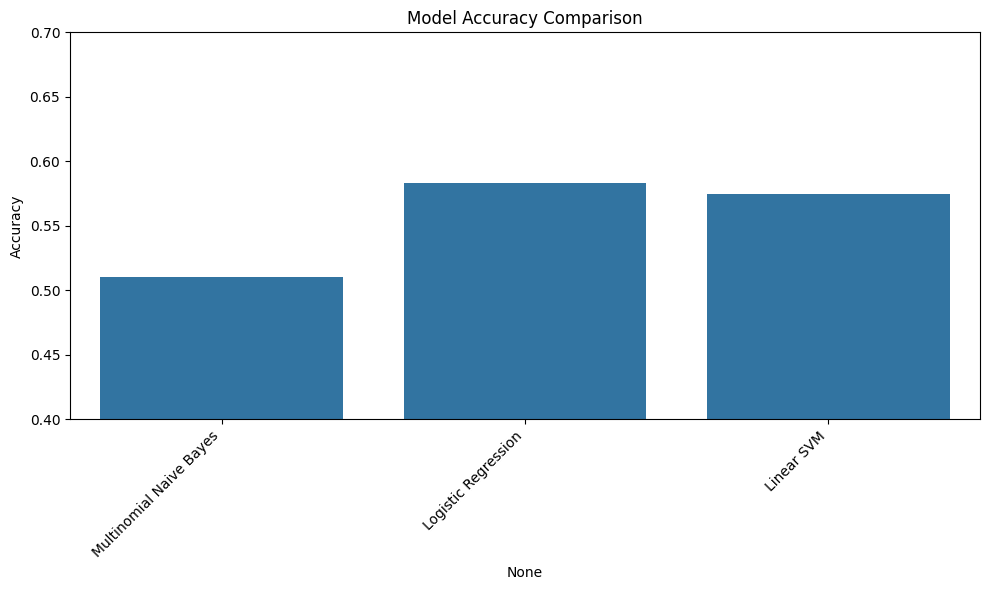

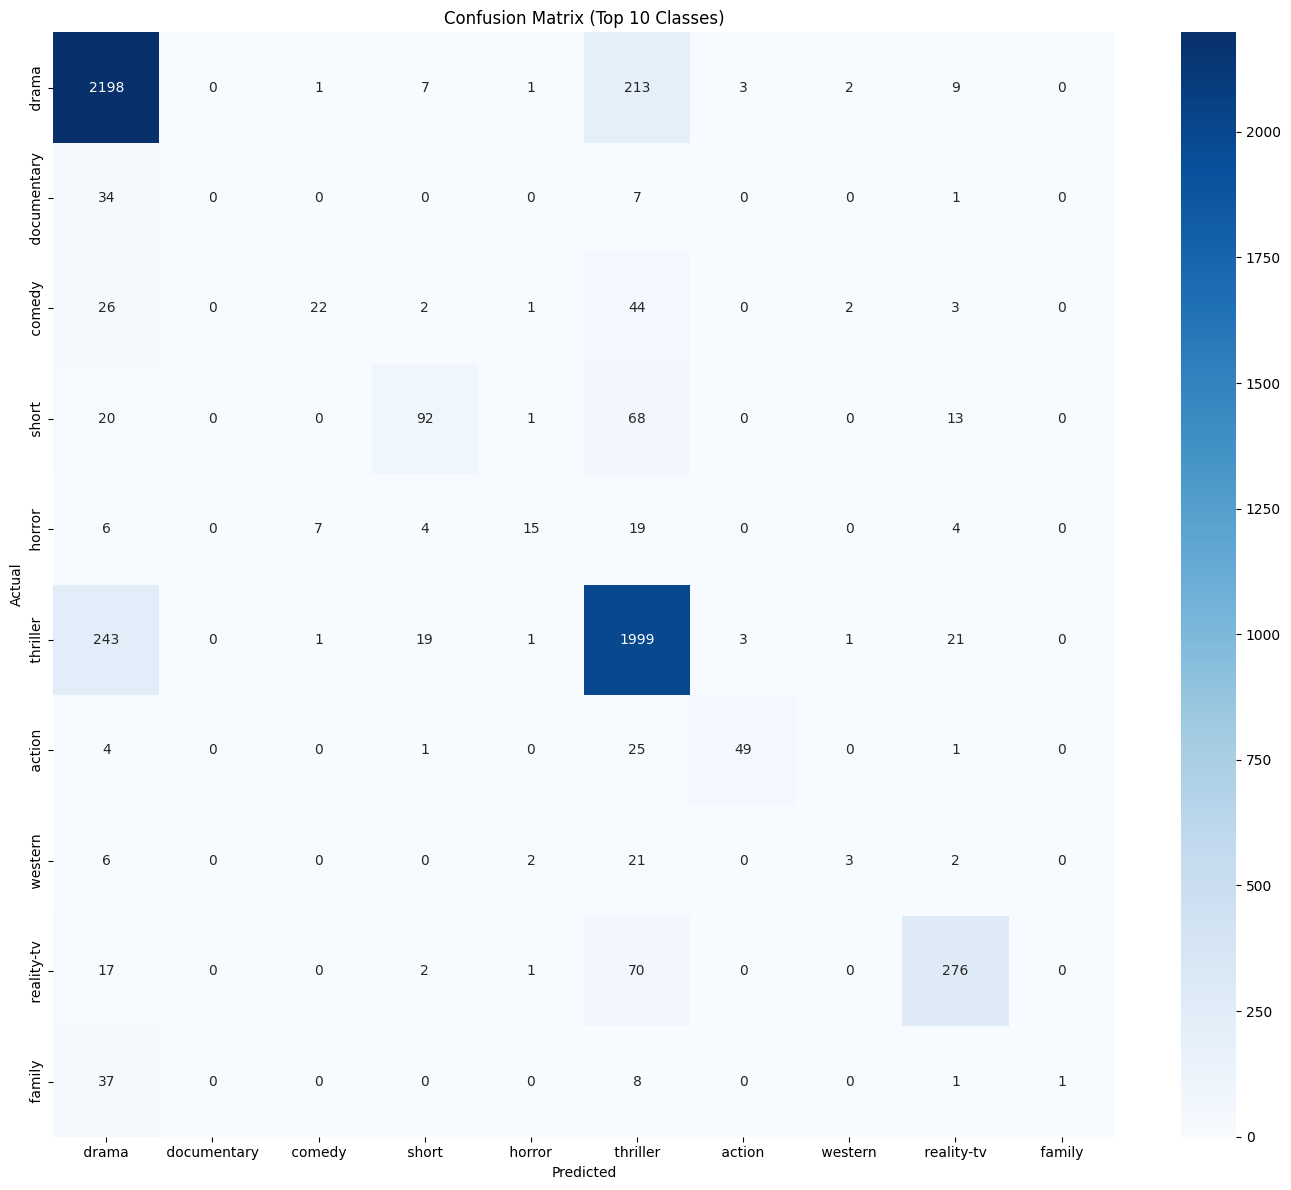

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# 1. Data Loading
print("Loading the datasets...")
train_data = pd.read_csv('train_data.txt', sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], engine='python')
test_data = pd.read_csv('test_data.txt', sep=':::', names=['ID', 'TITLE', 'DESCRIPTION'], engine='python')
test_solutions = pd.read_csv('test_data_solution.txt', sep=':::', names=['ID', 'GENRE'], engine='python')

# 2. Data Exploration
print("\nExploring the training data:")
print(f"Train data shape: {train_data.shape}")
print(train_data.head())

print("\nGenre distribution in training data:")
genre_counts = train_data['GENRE'].value_counts()
print(genre_counts)

# Plot genre distribution
plt.figure(figsize=(12, 6))
top_genres = genre_counts.head(15)  # Just show top 15 genres for clarity
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.title('Top 15 Genres Distribution in Training Data')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('top_genres_distribution.png')

# Check for missing values
print("\nMissing values in train data:")
print(train_data.isnull().sum())

# 3. Text Preprocessing
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize, remove stopwords and lemmatize
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))

        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        return ' '.join(tokens)
    else:
        return ""

print("Preprocessing text data...")
train_data['PROCESSED_TEXT'] = train_data['DESCRIPTION'].apply(preprocess_text)
test_data['PROCESSED_TEXT'] = test_data['DESCRIPTION'].apply(preprocess_text)

print("\nSample of processed text:")
print(train_data[['DESCRIPTION', 'PROCESSED_TEXT']].head(2))

# 4. Feature Extraction and Model Training
X = train_data['PROCESSED_TEXT']
y = train_data['GENRE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Feature extraction - TF-IDF
print("\nExtracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print(f"TF-IDF feature dimensions: {X_train_tfidf.shape}")

# Define models to evaluate - skip Random Forest as it's too slow
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0, solver='liblinear'),
    'Linear SVM': LinearSVC(C=1.0, max_iter=5000, dual=False)
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    model_results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred, zero_division=0))

# Find the best model
best_model_name = max(model_results, key=model_results.get)
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with accuracy {model_results[best_model_name]:.4f}")

# Plot model comparison
plt.figure(figsize=(10, 6))
models_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['Accuracy'])
sns.barplot(x=models_df.index, y='Accuracy', data=models_df)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.4, 0.7)
plt.tight_layout()
plt.savefig('model_comparison.png')

# 5. Hyperparameter Tuning for the Best Model - Manual Approach
print("\nPerforming hyperparameter tuning for the best model...")

if best_model_name == 'Multinomial Naive Bayes':
    print("Tuning Multinomial Naive Bayes...")
    alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0]
    best_alpha = 0
    best_score = 0

    for alpha in alpha_values:
        model = MultinomialNB(alpha=alpha)
        model.fit(X_train_tfidf, y_train)
        score = accuracy_score(y_val, model.predict(X_val_tfidf))
        print(f"Alpha = {alpha}, Accuracy = {score:.4f}")

        if score > best_score:
            best_score = score
            best_alpha = alpha

    print(f"Best alpha: {best_alpha} with accuracy: {best_score:.4f}")
    best_model = MultinomialNB(alpha=best_alpha)
    best_model.fit(X_train_tfidf, y_train)

elif best_model_name == 'Logistic Regression':
    print("Tuning Logistic Regression...")
    c_values = [0.1, 0.5, 1.0, 5.0, 10.0]
    solvers = ['liblinear', 'saga']
    best_c = 0
    best_solver = ''
    best_score = 0

    for c in c_values:
        for solver in solvers:
            model = LogisticRegression(C=c, solver=solver, max_iter=2000)
            model.fit(X_train_tfidf, y_train)
            score = accuracy_score(y_val, model.predict(X_val_tfidf))
            print(f"C = {c}, Solver = {solver}, Accuracy = {score:.4f}")

            if score > best_score:
                best_score = score
                best_c = c
                best_solver = solver

    print(f"Best parameters: C={best_c}, Solver={best_solver} with accuracy: {best_score:.4f}")
    best_model = LogisticRegression(C=best_c, solver=best_solver, max_iter=2000)
    best_model.fit(X_train_tfidf, y_train)

elif best_model_name == 'Linear SVM':
    print("Tuning Linear SVM...")
    c_values = [0.1, 0.5, 1.0, 5.0, 10.0]
    best_c = 0
    best_score = 0

    for c in c_values:
        model = LinearSVC(C=c, max_iter=5000, dual=False)
        model.fit(X_train_tfidf, y_train)
        score = accuracy_score(y_val, model.predict(X_val_tfidf))
        print(f"C = {c}, Accuracy = {score:.4f}")

        if score > best_score:
            best_score = score
            best_c = c

    print(f"Best C: {best_c} with accuracy: {best_score:.4f}")
    best_model = LinearSVC(C=best_c, max_iter=5000, dual=False)
    best_model.fit(X_train_tfidf, y_train)

# Evaluate final tuned model on validation set
tuned_y_pred = best_model.predict(X_val_tfidf)
tuned_accuracy = accuracy_score(y_val, tuned_y_pred)
print(f"\nTuned model accuracy on validation set: {tuned_accuracy:.4f}")
print(classification_report(y_val, tuned_y_pred, zero_division=0))

# 6. Confusion Matrix for Best Model
print("\nGenerating confusion matrix for the best model...")
conf_matrix = confusion_matrix(y_val, tuned_y_pred)

plt.figure(figsize=(14, 12))
# Get top classes for better visualization
top_classes = y_val.value_counts().head(10).index.tolist()
top_indices = [list(y_val.unique()).index(cls) for cls in top_classes]
top_conf_matrix = conf_matrix[top_indices, :][:, top_indices]

sns.heatmap(top_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_classes,
            yticklabels=top_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Top 10 Classes)')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# 7. Feature Importance Analysis (for interpretable models)
print("\nAnalyzing feature importance...")

def get_top_features_per_class(vectorizer, model, class_labels, top_n=10):
    """Get the top features for each class."""
    feature_names = vectorizer.get_feature_names_out()

    if hasattr(model, 'coef_'):
        coefs = model.coef_
        top_features = {}

        for i, class_label in enumerate(class_labels):
            if i < len(coefs):  # Ensure we have coefficients for this class
                # Get the coefficients for this class
                class_coef = coefs[i]
                # Get the indices of the top features
                top_indices = np.argsort(class_coef)[::-1][:top_n]
                # Store the feature names and coefficients
                top_features[class_label] = [(feature_names[idx], class_coef[idx]) for idx in top_indices]

        return top_features
    else:
        return {"Feature importance not available for this model type": []}

if hasattr(best_model, 'coef_'):
    class_labels = best_model.classes_
    top_features_per_class = get_top_features_per_class(tfidf_vectorizer, best_model, class_labels)

    print("\nTop features for selected genres:")
    # Display top features for a few interesting genres
    selected_genres = ['comedy', 'drama', 'horror', 'documentary', 'sci-fi']
    for genre in selected_genres:
        if genre in top_features_per_class:
            print(f"\nTop features for {genre}:")
            for feature, importance in top_features_per_class[genre][:10]:
                print(f"{feature}: {importance:.4f}")
else:
    print("Feature importance analysis not available for this model type.")

# 8. Predictions on Test Set
print("\nMaking predictions on the test set...")
X_test_tfidf = tfidf_vectorizer.transform(test_data['PROCESSED_TEXT'])
test_predictions = best_model.predict(X_test_tfidf)

# Create a submission dataframe
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'TITLE': test_data['TITLE'],
    'PREDICTED_GENRE': test_predictions
})

# If we have the test solutions, we can evaluate the model's performance
merged_test = test_data.merge(test_solutions, on='ID')
test_accuracy = accuracy_score(test_solutions['GENRE'], test_predictions)
print(f"Test set accuracy: {test_accuracy:.4f}")
print(classification_report(test_solutions['GENRE'], test_predictions, zero_division=0))

print("Saving predictions to submission.csv...")
submission.to_csv('submission.csv', index=False)

# 9. Sample Prediction Function
def predict_genre(description, vectorizer=tfidf_vectorizer, model=best_model):
    """
    Predicts the genre of a movie based on its description.

    Args:
        description (str): Movie description text
        vectorizer: Trained TF-IDF vectorizer
        model: Trained classification model

    Returns:
        str: Predicted genre
    """
    processed_text = preprocess_text(description)
    text_tfidf = vectorizer.transform([processed_text])
    return model.predict(text_tfidf)[0]

# Example usage of the prediction function
sample_descriptions = [
    "A young wizard discovers he has magical powers and attends a school of witchcraft and wizardry where he learns to harness his abilities.",
    "A group of friends go camping in the woods, but they are stalked by a mysterious killer who picks them off one by one.",
    "The true story of a famous explorer's journey across the Atlantic ocean in a homemade raft."
]

print("\nSample predictions:")
for desc in sample_descriptions:
    genre = predict_genre(desc)
    print(f"Description: {desc[:50]}...")
    print(f"Predicted Genre: {genre}\n")

# 10. Error Analysis
print("\nPerforming error analysis on validation set...")
misclassified_indices = np.where(y_val != tuned_y_pred)[0]

if len(misclassified_indices) > 0:
    misclassified_samples = pd.DataFrame({
        'Actual Genre': y_val.iloc[misclassified_indices].reset_index(drop=True),
        'Predicted Genre': tuned_y_pred[misclassified_indices],
        'Description': X_val.iloc[misclassified_indices].reset_index(drop=True)
    })

    print(f"Number of misclassified samples: {len(misclassified_indices)}")

    # Analyze common misclassification patterns
    misclass_pairs = misclassified_samples.groupby(['Actual Genre', 'Predicted Genre']).size().reset_index(name='Count')
    misclass_pairs = misclass_pairs.sort_values('Count', ascending=False)

    print("\nMost common misclassification patterns:")
    print(misclass_pairs.head(10))

    # Plot most common misclassifications
    plt.figure(figsize=(12, 8))
    top_misclass = misclass_pairs.head(10)
    sns.barplot(x='Count', y=top_misclass['Actual Genre'] + ' → ' + top_misclass['Predicted Genre'], data=top_misclass)
    plt.title('Top 10 Misclassification Patterns')
    plt.tight_layout()
    plt.savefig('misclassification_patterns.png')

    # Save misclassified samples for further analysis
    misclassified_samples.to_csv('misclassified_samples.csv', index=False)
else:
    print("No misclassifications found in the validation set!")

print("\nMovie genre classification project completed successfully!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Loading the datasets...

Exploring the training data:
Train data shape: (49738, 4)
  ID                               TITLE       GENRE  \
0  1       Oscar et la dame rose (2009)       drama    
1  2                       Cupid (1997)    thriller    
2  3   Young, Wild and Wonderful (1980)       adult    
3  4              The Secret Sin (1915)       drama    
4  5             The Unrecovered (2007)       drama    

                                         DESCRIPTION  
0   Listening in to a conversation between his do...  
1   A brother and sister with a past incestuous r...  
2   As the bus empties the students for their fie...  
3   To help their unemployed father make ends mee...  
4   The film's title refers not only to the un-re...  

Genre distribution in training data:
GENRE
drama           12496
documentary     12033
comedy           6825
short            4646
horror           2019
thriller         1467
action           1207
western           942
reality-tv        813
family  

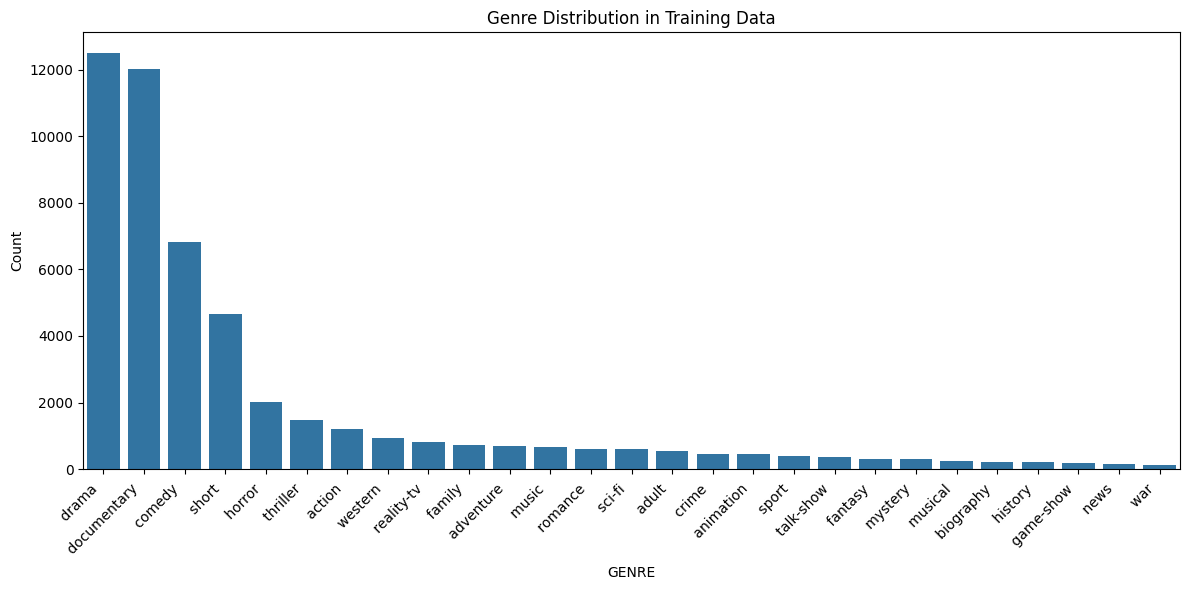

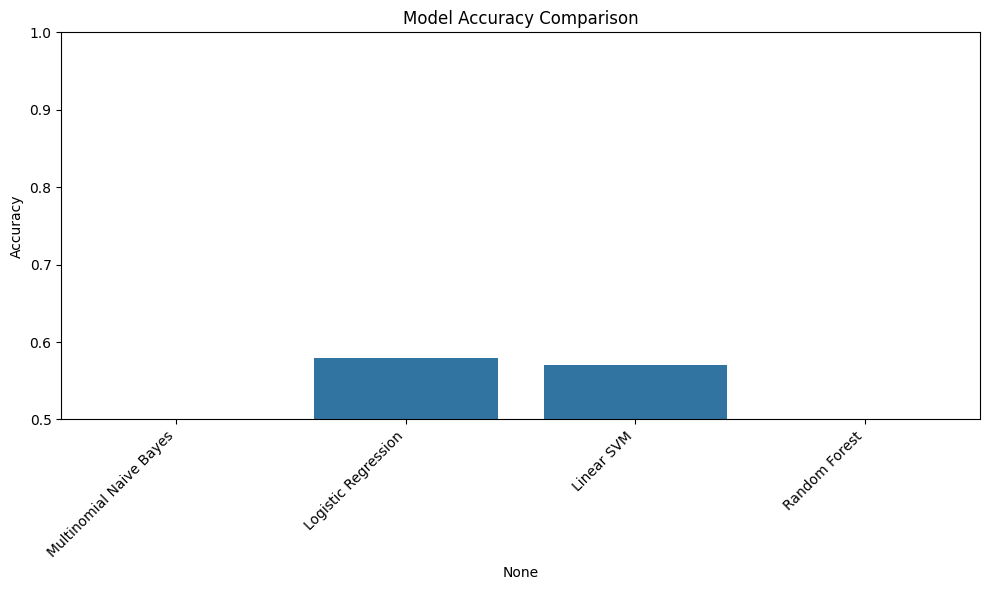

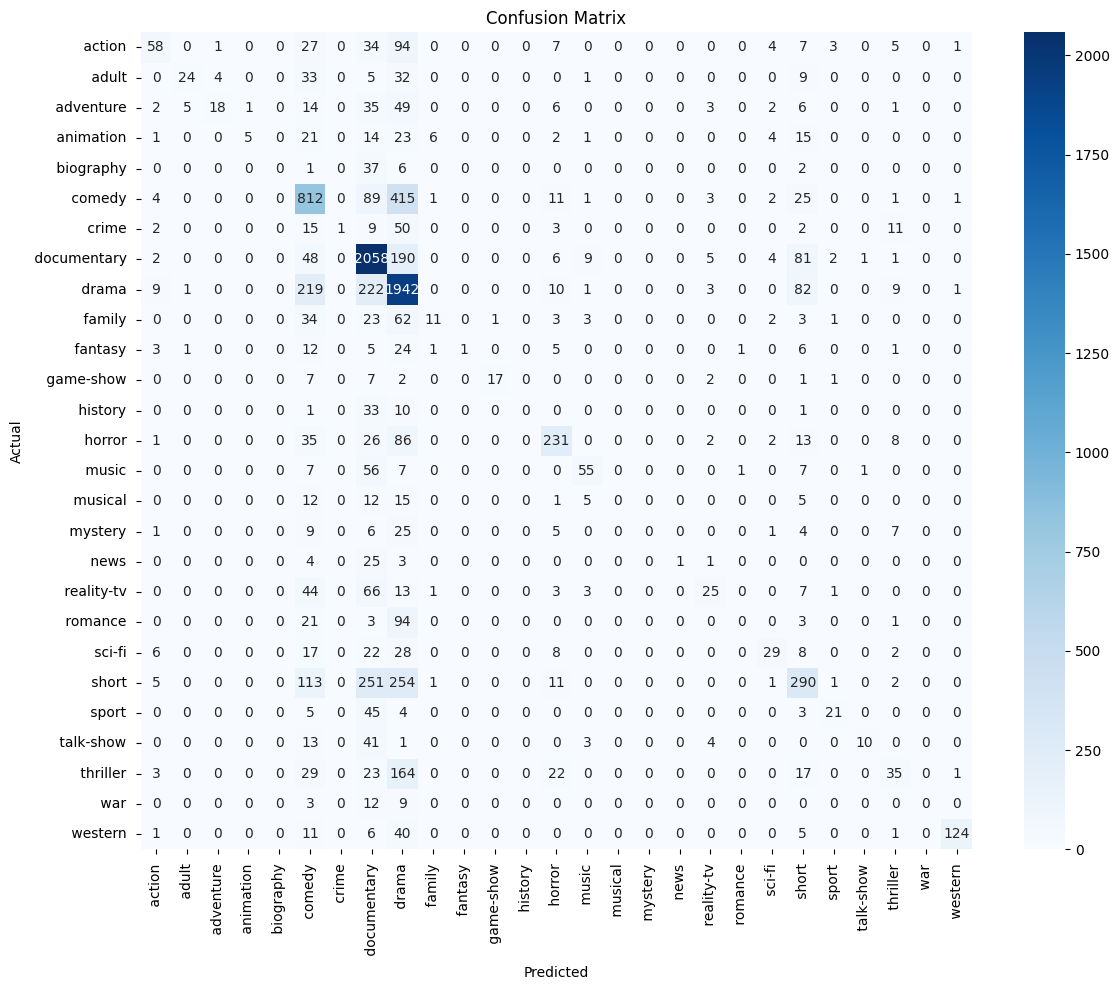

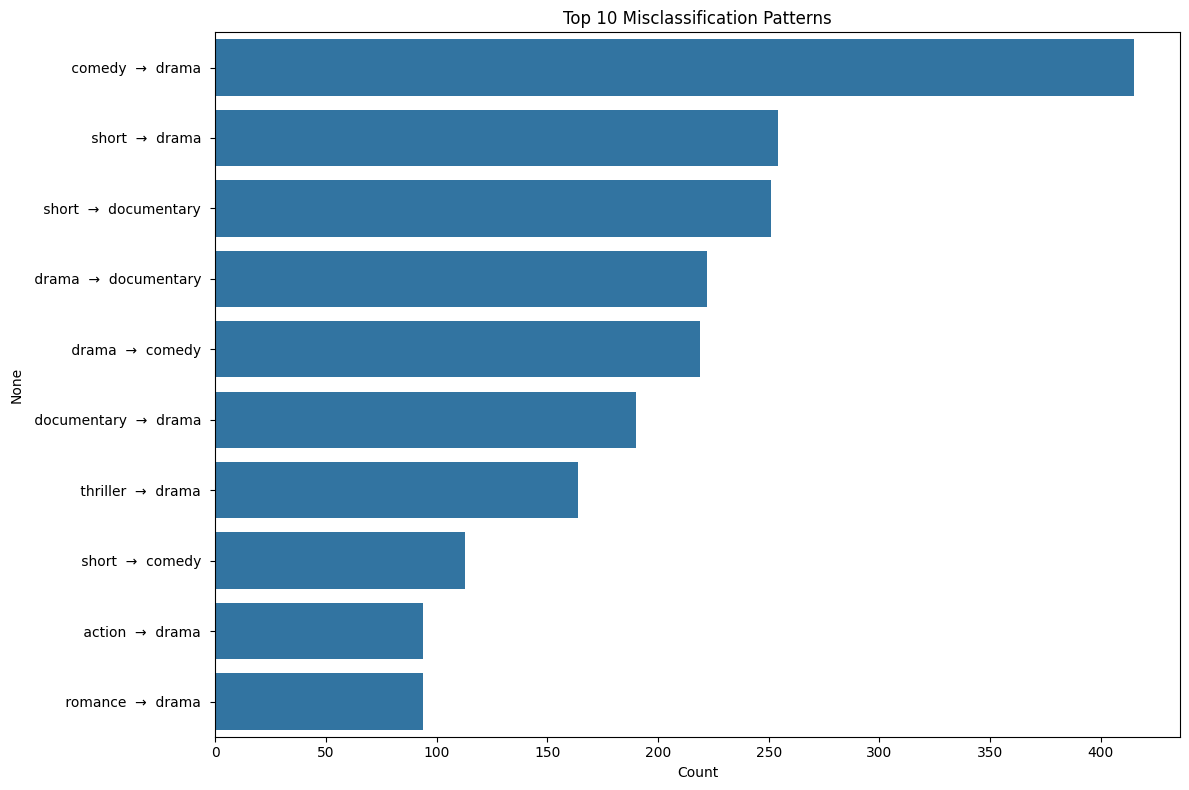

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# 1. Data Loading
print("Loading the datasets...")
# Using engine='python' to handle the custom delimiter :::
train_data = pd.read_csv('train_data.txt', sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], engine='python')
test_data = pd.read_csv('test_data.txt', sep=':::', names=['ID', 'TITLE', 'DESCRIPTION'], engine='python')
test_solutions = pd.read_csv('test_data_solution.txt', sep=':::', names=['ID', 'GENRE'], engine='python')

# Convert ID columns to string to avoid merge issues
train_data['ID'] = train_data['ID'].astype(str)
test_data['ID'] = test_data['ID'].astype(str)
test_solutions['ID'] = test_solutions['ID'].astype(str)

# 2. Data Exploration
print("\nExploring the training data:")
print(f"Train data shape: {train_data.shape}")
print(train_data.head())

print("\nGenre distribution in training data:")
genre_counts = train_data['GENRE'].value_counts()
print(genre_counts)

# Plot genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Genre Distribution in Training Data')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('genre_distribution.png')

# Check for missing values
print("\nMissing values in train data:")
print(train_data.isnull().sum())

# 3. Text Preprocessing
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize, remove stopwords and lemmatize
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))

        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        return ' '.join(tokens)
    else:
        return ""

print("Preprocessing text data...")
train_data['PROCESSED_TEXT'] = train_data['DESCRIPTION'].apply(preprocess_text)
test_data['PROCESSED_TEXT'] = test_data['DESCRIPTION'].apply(preprocess_text)

print("\nSample of processed text:")
print(train_data[['DESCRIPTION', 'PROCESSED_TEXT']].head(2))

# 4. Feature Extraction and Model Training
X = train_data['PROCESSED_TEXT']
y = train_data['GENRE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Define models to evaluate
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'Linear SVM': LinearSVC(C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Dictionary to store model results
model_results = {}

print("\nTraining and evaluating models with TF-IDF features:")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    model_results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred))

# Find the best model
best_model_name = max(model_results, key=model_results.get)
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with accuracy {model_results[best_model_name]:.4f}")

# Plot model comparison
plt.figure(figsize=(10, 6))
models_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['Accuracy'])
sns.barplot(x=models_df.index, y='Accuracy', data=models_df)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.savefig('model_comparison.png')

# 5. Hyperparameter Tuning for the Best Model - Fixed to avoid parameter passing issues
print("\nPerforming hyperparameter tuning for the best model...")

# Create pipeline parameters correctly with proper naming convention
if best_model_name == 'Multinomial Naive Bayes':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', MultinomialNB())
    ])
    param_grid = {
        'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
    }

elif best_model_name == 'Logistic Regression':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    param_grid = {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__solver': ['liblinear', 'saga']
    }

elif best_model_name == 'Linear SVM':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', LinearSVC())
    ])
    param_grid = {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__loss': ['hinge', 'squared_hinge']
    }

else:  # Random Forest
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)),
        ('classifier', RandomForestClassifier())
    ])
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }

# Perform grid search with reduced CV to save time
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
print("Starting grid search...")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate the tuned model on validation set
tuned_y_pred = grid_search.predict(X_val)
tuned_accuracy = accuracy_score(y_val, tuned_y_pred)
print(f"Tuned model accuracy on validation set: {tuned_accuracy:.4f}")

# 6. Confusion Matrix for Best Model
print("\nGenerating confusion matrix for the best model...")
conf_matrix = confusion_matrix(y_val, tuned_y_pred)

# Get unique genres for labels
unique_genres = sorted(train_data['GENRE'].unique())

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_genres,
            yticklabels=unique_genres)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# 7. Feature Importance Analysis
print("\nAnalyzing feature importance...")

def get_top_features_per_class(vectorizer, model, class_names, n=10):
    """Get top features for each class for linear models."""
    feature_names = vectorizer.get_feature_names_out()

    if hasattr(model, 'coef_'):
        top_features = {}

        # For linear models with coefficients per class
        for i, class_name in enumerate(class_names):
            if len(model.coef_.shape) > 1:  # Multi-class case
                if i < len(model.coef_):  # Ensure we don't go out of bounds
                    coefs = model.coef_[i]
                    top_indices = np.argsort(coefs)[-n:]
                    top_features[class_name] = [(feature_names[j], coefs[j]) for j in top_indices]
            else:  # Binary case
                coefs = model.coef_[0]
                top_indices = np.argsort(coefs)[-n:]
                top_features[class_name] = [(feature_names[j], coefs[j]) for j in top_indices]

        return top_features

    elif hasattr(model, 'feature_importances_'):  # For tree-based models
        importances = model.feature_importances_
        indices = np.argsort(importances)[-n:]
        return {
            'overall': [(feature_names[i], importances[i]) for i in indices]
        }

    else:
        return {'message': "Feature importance not available for this model type"}

# Get top features if the model supports it
if hasattr(grid_search, 'best_estimator_'):
    vectorizer = grid_search.best_estimator_.named_steps['tfidf']
    classifier = grid_search.best_estimator_.named_steps['classifier']

    top_features_by_class = {}

    # Get overall feature importance for non-linear models or per-class for linear models
    if best_model_name in ['Logistic Regression', 'Linear SVM']:
        # Get top 5 features for selected genres
        selected_genres = ['drama', 'comedy', 'documentary', 'horror', 'thriller']
        top_features_by_class = get_top_features_per_class(
            vectorizer, classifier, selected_genres, n=5
        )

        # Print top features for selected genres
        print("\nTop features for selected genres:")
        for genre, features in top_features_by_class.items():
            if isinstance(features, list):
                print(f"\n{genre.capitalize()}:")
                for feature, importance in features:
                    print(f"  {feature}: {importance:.4f}")

    elif best_model_name == 'Random Forest':
        # For Random Forest, get overall feature importance
        top_features = get_top_features_per_class(vectorizer, classifier, ['overall'], n=20)

        if 'overall' in top_features:
            print("\nTop 20 features across all genres:")
            for feature, importance in top_features['overall']:
                print(f"  {feature}: {importance:.4f}")

            # Plot feature importance
            plt.figure(figsize=(12, 8))
            feature_df = pd.DataFrame(top_features['overall'], columns=['Feature', 'Importance'])
            sns.barplot(x='Importance', y='Feature', data=feature_df)
            plt.title('Top Features Importance')
            plt.tight_layout()
            plt.savefig('feature_importance.png')

# 8. Predictions on Test Set
print("\nMaking predictions on the test set...")
test_predictions = grid_search.predict(test_data['PROCESSED_TEXT'])

# Create a submission dataframe
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'TITLE': test_data['TITLE'],
    'PREDICTED_GENRE': test_predictions
})

# Properly merge test data with test solutions for evaluation
try:
    # Make sure ID columns have the same type before merging
    test_data['ID'] = test_data['ID'].astype(str)
    test_solutions['ID'] = test_solutions['ID'].astype(str)

    # Merge both DataFrames on ID
    merged_test = pd.merge(test_data, test_solutions, on='ID')

    # Evaluate accuracy on test set
    test_accuracy = accuracy_score(merged_test['GENRE'], test_predictions)
    print(f"Test set accuracy: {test_accuracy:.4f}")
    print(classification_report(merged_test['GENRE'], test_predictions))
except Exception as e:
    print(f"Could not evaluate test accuracy: {e}")
    print("Continuing without test evaluation...")

print("Saving predictions to submission.csv...")
submission.to_csv('submission.csv', index=False)

# 9. Sample Prediction Function
def predict_genre(description, pipeline=grid_search):
    """
    Predicts the genre of a movie based on its description.

    Args:
        description (str): Movie description text
        pipeline: Trained model pipeline

    Returns:
        str: Predicted genre
    """
    processed_text = preprocess_text(description)
    return pipeline.predict([processed_text])[0]

# Example usage of the prediction function
sample_description = "A young wizard discovers he has magical powers and attends a school of witchcraft and wizardry where he learns to harness his abilities."
predicted_genre = predict_genre(sample_description)
print(f"\nSample prediction:")
print(f"Description: {sample_description}")
print(f"Predicted Genre: {predicted_genre}")

# 10. Error Analysis
print("\nPerforming error analysis on validation set...")
misclassified_indices = np.where(y_val != tuned_y_pred)[0]

if len(misclassified_indices) > 0:
    misclassified_samples = pd.DataFrame({
        'Actual Genre': y_val.iloc[misclassified_indices].reset_index(drop=True),
        'Predicted Genre': tuned_y_pred[misclassified_indices],
        'Description': X_val.iloc[misclassified_indices].reset_index(drop=True)
    })

    print(f"Number of misclassified samples: {len(misclassified_indices)}")
    print("\nSample misclassifications:")
    print(misclassified_samples.head(5))

    # Save misclassified samples for further analysis
    misclassified_samples.to_csv('misclassified_samples.csv', index=False)

    # Analyze common misclassification patterns
    misclass_pairs = misclassified_samples.groupby(['Actual Genre', 'Predicted Genre']).size().reset_index(name='Count')
    misclass_pairs = misclass_pairs.sort_values('Count', ascending=False)

    print("\nMost common misclassification patterns:")
    print(misclass_pairs.head(10))

    # Plot most common misclassifications
    plt.figure(figsize=(12, 8))
    top_misclass = misclass_pairs.head(10)
    sns.barplot(x='Count', y=top_misclass['Actual Genre'] + ' → ' + top_misclass['Predicted Genre'], data=top_misclass)
    plt.title('Top 10 Misclassification Patterns')
    plt.tight_layout()
    plt.savefig('misclassification_patterns.png')
else:
    print("No misclassifications found in the validation set!")

print("\nMovie genre classification project completed successfully!")